In [356]:

import numpy as np
import dill
import importlib
import sys
import os
import matplotlib.pyplot as plt
import data_visualization as dv
import copy
import numba as nb
'''
v4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3

As of 1/13/23, the only change is the addition of the decision to action delay
'''

'\nv4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3\n\nAs of 1/13/23, the only change is the addition of the decision to action delay\n'

# Select Exp1 or Exp2

In [357]:
experiment = 'Exp1'

In [358]:
sys.path.insert(0, r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement') 
sys.path.insert(0, r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Optimal_Model\Analysis') 
import read_data_functions as rdf
import Optimal_Stopping_Object_v4
import Subject_Object_v2 
import plot_functions as pf
importlib.reload(pf)

importlib.reload(Optimal_Stopping_Object_v4) # Reloads so I don't have to restart kernel if I change a function in the Object of another py file

D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Optimal_Model\Analysis\Optimal_Stopping_Object_v4.py:73: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "vector_cdf" failed type inference due to: No implementation of function Function(<function cdf at 0x000001C783493A60>) found for signature:
 
 >>> cdf(float64, float64, float64)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function '_ol_cdf': File: D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_Exp1\<string>: Line 0.
        With argument(s): '(float64, float64, float64)':
       Rejected as the implementation raised a specific error:
         TypingError: first argument must be an array of floating point type
  raised from c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numba_stats\_util.py:49

During: resolving callee type: Function(<function cdf at 0x000001C7

<module 'Optimal_Stopping_Object_v4' from 'D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\Optimal_Model\\Analysis\\Optimal_Stopping_Object_v4.py'>

# Initial Thangs

In [359]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Initial thangs
os.chdir(f'D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}')
PATH = os.getcwd()
SAVE_PATH = f'D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
if experiment == 'Exp2':
    tp3_title = "Win = 1\nIncorrect = 0\nIndecision = 0"
    tp4_title = "Win = 1\nIncorrect = -1\nIndecision = 0"
    tp5_title = "Win = 1\nIncorrect = 0\nIndecision = -1"
    tp6_title = "Win = 1\nIncorrect = -1\nIndecision = -1"
    trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title]
    num_blocks = len(trial_block_titles)
    xlabel = 'Payoff Condition'
if experiment == 'Exp1':
    tp3_title = "1000 (50)"
    tp4_title = "1000 (150)"
    tp5_title = '1100 (50)'
    tp6_title = "1100 (150)"
    tp7_title = "1200 (50)"
    tp8_title = '1200 (150)'
    trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]
    num_blocks = len(trial_block_titles)
    xlabel = 'Mean [SD] Agent Decision Time (ms)'

num_subjects

20

In [360]:
mask = np.array([[True,False],[True,False]])
a = np.array([[1,2],[3,4]])


# Pickle Data

In [361]:
if 'subject_objects' not in locals():
    subject_objects = rdf.generate_subject_objects(experiment)
    subject_objects2 = copy.deepcopy(subject_objects)
    # group = Subject_Object_v2.Group(subject_objects, select_trials = 'All Trials', num_stds_for_reaction_time = 2, 
    #                                     task_leave_time_metric_name = 'player_pos_task_leave_time', task_movement_time_metric_name = 'player_pos_task_movement_time',
    #                                     reaction_time_metric_name = 'player_pos_reaction_time', reaction_movement_time_metric_name = 'player_pos_reaction_movement_time')
    # group.analyze_data()
    group = Subject_Object_v2.Group(subject_objects2, select_trials = 'All Trials', num_stds_for_reaction_time = 2, 
                                        task_leave_time_metric_name = 'player_velocity_task_leave_time_thresh',task_movement_time_metric_name = 'player_velocity_task_movement_time_thresh',
                                        reaction_time_metric_name = 'player_velocity_reaction_time_thresh', reaction_movement_time_metric_name = 'player_velocity_reaction_movement_time_thresh')
    group.analyze_data()


# Create Model

In [362]:
if experiment == 'Exp1':
    rt                   = np.nanmedian(np.nanmedian(group.reaction_time,axis=1))
    rt_sd                = np.nanmedian(np.nanstd(group.reaction_time,axis=1))
    
elif experiment == 'Exp2':
    rt                   = np.nanmedian(np.nanmedian(group.react_reaction_time_only_react,axis=1)) - 30
    rt_sd                = np.nanmedian(np.nanstd(group.reaction_time,axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.player_task_movement_time,axis=2),axis=0)) - 10 # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.player_task_movement_time,axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.coincidence_reach_time,axis=1))]*num_blocks)
perc_wins_both_reach = np.nanmean(group.perc_gamble_wins_when_both_decide,axis=0)
gamble_uncertainty   = np.nanmedian(np.nanstd(group.player_gamble_task_leave_time,axis=2),axis=0)
agent_sds                = np.nanmean(np.nanstd(group.agent_task_leave_time,axis=2),axis=0)
agent_means              = np.nanmean(np.nanmean(group.agent_task_leave_time,axis=2),axis=0) 
    
optimal_model_full_knowledge = Optimal_Stopping_Object_v4.Optimal_Decision_Time_Model(
    experiment=experiment, num_blocks = len(agent_means), BETA_ON = False, numba = False,
    agent_means = agent_means,agent_sds = agent_sds, 
    reaction_time = rt, movement_time = mt,
    reaction_uncertainty = rt_sd, movement_uncertainty = mt_sd,
    timing_uncertainty = time_sd,
    perc_wins_when_both_reach = perc_wins_both_reach,
    gamble_delay_known = True, gamble_uncertainty_known = True,
    true_gamble_uncertainty= gamble_uncertainty, expected_gamble_uncertainty = np.array([10]*num_blocks),
    true_gamble_delay = 125, expected_gamble_delay = 50,
    include_agent_sd_in_gamble_uncertainty = False,
    weird_reaction_gamble_cutoff = 0,
    )
optimal_model_full_knowledge.run_model()

optimal_model_no_knowledge = Optimal_Stopping_Object_v4.Optimal_Decision_Time_Model(
    experiment=experiment, num_blocks = len(agent_means), BETA_ON = False, numba = False,
    agent_means = agent_means,agent_sds = agent_sds, 
    reaction_time = rt, movement_time = mt,
    reaction_uncertainty = rt_sd, movement_uncertainty = mt_sd,
    timing_uncertainty = time_sd,
    perc_wins_when_both_reach = perc_wins_both_reach,
    gamble_delay_known = False, gamble_uncertainty_known = False,
    true_gamble_uncertainty= gamble_uncertainty, expected_gamble_uncertainty = np.array([10]*num_blocks),
    true_gamble_delay = 125, expected_gamble_delay = 50,
    include_agent_sd_in_gamble_uncertainty = False,
    weird_reaction_gamble_cutoff = 0,
    )
optimal_model_no_knowledge.run_model()

group_model_true = copy.deepcopy(optimal_model_full_knowledge)
group_model_expected = copy.deepcopy(optimal_model_full_knowledge)


D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Optimal_Model\Analysis\Optimal_Stopping_Object_v4.py:69: RuntimeWarning: invalid value encountered in subtract
  ans = EX2 - EX**2
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Optimal_Model\Analysis\Optimal_Stopping_Object_v4.py:63: RuntimeWarning: invalid value encountered in subtract
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Optimal_Model\Analysis\Optimal_Stopping_Object_v4.py:63: RuntimeWarning: invalid value encountered in power
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))


# Tune Model

In [363]:
@nb.njit(parallel=False)
def find_optimal_decision_time_for_certain_metric(rts,mts):
    # print(type(rts))
    a = 5+2
    ans = np.empty((4,4,4))
    for i in range(len(rts)):
        for j in range(len(mts)):
            pass
            # ob.reaction_time = rts[i]
            # ob.movement_time = mts[j]
            # ob.run_model()
            # ans[i,j,:] = ob.optimal_decision_time 
    return ans

In [364]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.9f}".format(x)})
o = group_model_true
if (o.true_gamble_uncertainty == o.expected_gamble_uncertainty).all():
    known_gamble_uncertainty = True     
if o.true_gamble_delay == o.expected_gamble_delay:
    known_gamble_uncertainty = True  

print(f'Reaction Time Mean (SD):    {o.reaction_time:0.3f} ({o.reaction_uncertainty:0.3f})')
print(f'Movement Time Mean (SD):    {o.movement_time:0.3f} ({o.movement_uncertainty:0.3f})')
print(f'Timing Uncertainty:         {o.timing_uncertainty}')
print(f'True Gamble Delay:          {o.true_gamble_delay}')
print(f'Expected Gamble Delay:      {o.expected_gamble_delay}')
print(f'True Gamble Uncertainty:     {o.true_gamble_uncertainty}')
print(f'Expected Gamble Uncertainty: {o.expected_gamble_uncertainty}')
print(f'Reaction Gamble Cutoff:      {o.weird_reaction_gamble_cutoff}')

Reaction Time Mean (SD):    266.250 (37.695)
Movement Time Mean (SD):    147.250 (26.543)
Timing Uncertainty:         [76.613683280 76.613683280 76.613683280 76.613683280 76.613683280
 76.613683280]
True Gamble Delay:          125
Expected Gamble Delay:      125
True Gamble Uncertainty:     [74.730052475 115.394910923 90.163114907 115.572582759 134.376678378
 136.978197553]
Expected Gamble Uncertainty: [74.730052475 115.394910923 90.163114907 115.572582759 134.376678378
 136.978197553]
Reaction Gamble Cutoff:      0


In [365]:
if False:
    data_wins = np.median(group.player_perc_wins,axis=0)
    data_indecisions = np.median(group.player_perc_indecisions,axis=0)
    data_incorrects = np.median(group.player_perc_incorrects,axis=0)
    data_leave_target_time = np.median(np.nanmedian(group.player_task_leave_time,axis=2),axis=0)
    data_reaction_decisions = np.median(group.perc_reaction_decisions,axis=0)
    data_gamble_decisions = np.median(group.perc_gamble_decisions,axis=0)
    data_reaction_leave_time = np.nanmedian(np.nanmedian(group.player_reaction_task_leave_time,axis=2),axis=0)
    data_gamble_leave_time = np.nanmedian(np.nanmedian(group.player_gamble_task_leave_time,axis=2),axis=0)
    tune_data = [data_wins,data_indecisions,data_incorrects,data_leave_target_time,
                data_reaction_decisions,data_gamble_decisions,data_reaction_leave_time,data_gamble_leave_time]
    
    group_model.fit_model_to_data(tune_data)
    group_model = group_model
    group_model.calculate_metrics_with_certain_decision_time(group_model.fit_decision_times_dict['Leave Target Time'],final=True)

In [366]:
group_model_true.fit_model('wtd_optimal_true_leave_target_time',np.nanmedian(np.nanmedian(group.player_task_leave_time,axis=2),axis=0),)
group_model_expected.fit_model('wtd_optimal_expected_leave_target_time',np.nanmedian(np.nanmedian(group.player_task_leave_time,axis=2),axis=0),)

In [367]:
# group_model_true.calculate_metrics_with_certain_decision_time(np.array([1100]*6)) 
# group_model_expected.calculate_metrics_with_certain_decision_time(np.array([1100]*6)) 

# NOTE

## IMPORTANT!
When Known is False, then the optimal_model_full_knowledge.true_metric will be what happens when I pick an optimal based on what I THINK my delay is, 

and then I actually get the metric where the true values apply

## Less important

- Fitting to the TRUE gamble delay gives EARLIER stopping time
- Fitting to the TRUE gamble uncertainty should not impact the stopping time (NEED TO CHECK THIS)

- EARLIER stopping time, means less gamble indecisions, and less reaction 

- *OPTIMAL_TRUE metrics ALWAYS account for the true gamble delay and uncertainty, regardless of known or unknown or what the expected gamble and uncertainty are
----
- Group model true fits to the wtd_optimal_true_leave_target_time
    - MEANING, that it selects the OPTIMAL STOPPING TIME using the GAMBLE DELAY = 150 and GAMBLE UNCERTAINTY = FROM DATA
----
- Group model expected fits to the wtd_optimal_EXPECTED_leave_target_time
    - MEANING, that it selects the OPTIMAL STOPPING TIME using the GAMBLE DELAY = 50 and GAMBLE UNCERTAINTY = timing_sd + 10
----
WHEN KNOWN IS FALSE
- AND I FIT STOPPING TIME TO THE TRUE GAMBLE STUFF
    - THEN EXPECTED METRICS for that model WILL BE THE RESULT OF fitting to some gamble delay, but not incorporating that gamble delay/uncertainty into the prediction of the metrics
    - So that's like participants picking a stopping time 

In [368]:
# group_model.plot_optimals(metrics = ['exp_reward','prob_making_given_reaction','prob_indecision_given_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_gamble','prob_selecting_reaction'])

# Plots

In [369]:
save = False

Predicted Decision Time

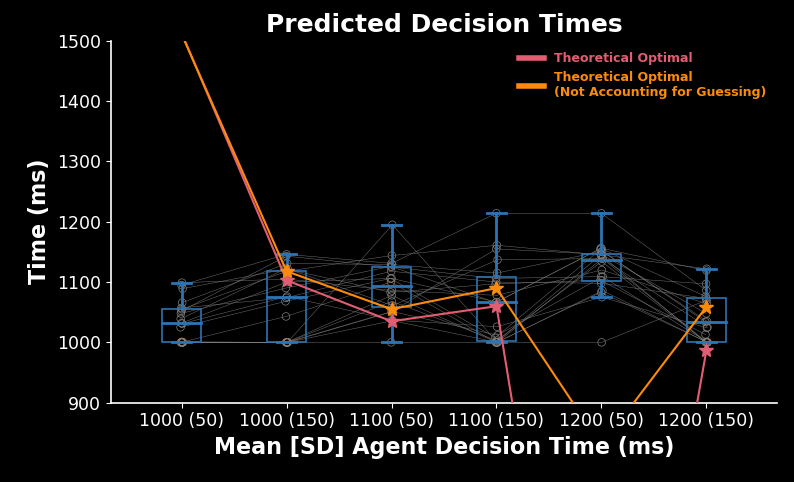

In [370]:
group.predict_stopping_times(optimal_model_full_knowledge.true_gamble_delay)
metric = group.combine_all_subjects('player_stopping_times')
group_model_metric_true = group_model_true.optimal_decision_time
group_model_metric_expected = group_model_expected.optimal_decision_time
optimal_model_metric_true = optimal_model_full_knowledge.optimal_decision_time
optimal_model_metric_expected = optimal_model_no_knowledge.optimal_decision_time
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(900,1600,100)
bw = 0.75
pf.multiple_models_boxplot(ax,metric,show_boxplot=True,
                           expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                           group_model_true = None, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,linestyles = ['-']*4,
                            remove_parentheses_from_labels = False)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel('Time (ms)')
ax.set_title('Predicted Decision Times')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

(0.0, 100.0)

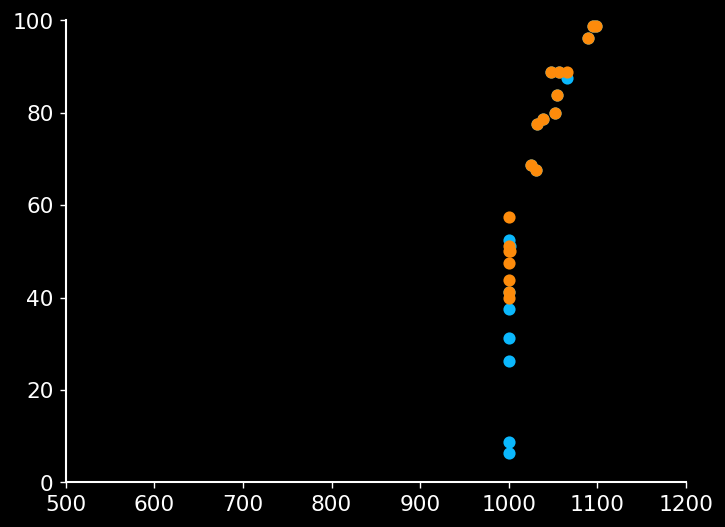

In [371]:
fig,ax = plt.subplots(dpi=125)
ax.scatter(group.combine_all_subjects('player_stopping_times')[:,0],group.perc_reaction_decisions[:,0])
ax.scatter(group.combine_all_subjects('player_stopping_times')[:,0],group.combine_all_subjects('predicted_perc_reaction_decisions')[:,0])
ax.set_xlim(500,1200)
ax.set_ylim(0,100)

LEave Target Time

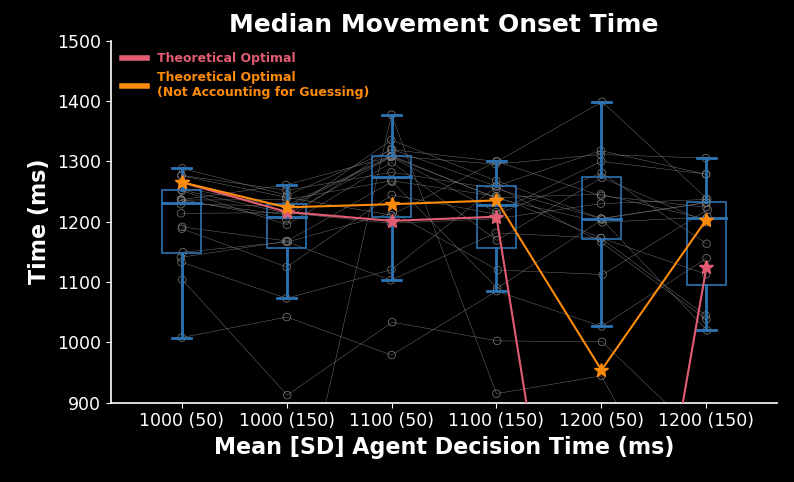

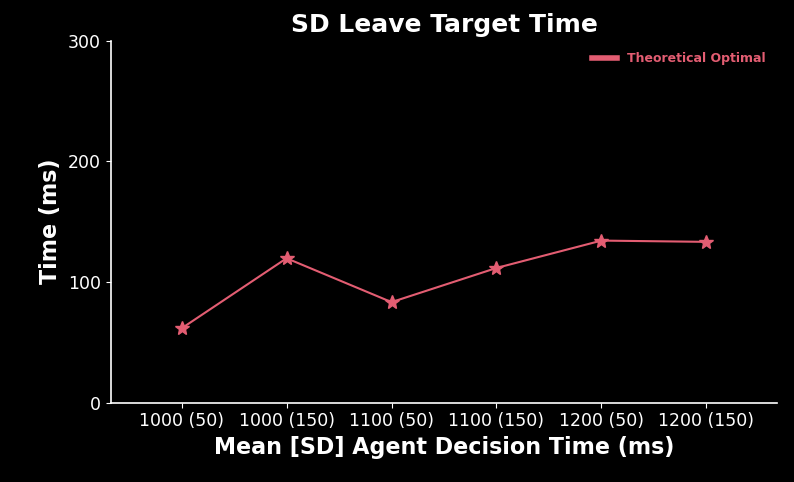

In [403]:
metric = np.nanmedian(group.player_task_leave_time,axis=2)
group_model_metric_true = group_model_true.wtd_optimal_true_leave_target_time
group_model_metric_expected = group_model_expected.wtd_optimal_expected_leave_target_time
optimal_model_metric_true = optimal_model_full_knowledge.wtd_optimal_true_leave_target_time
optimal_model_metric_expected = optimal_model_no_knowledge.wtd_optimal_true_leave_target_time
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(900,1600,100)
bw = 0.75
pf.multiple_models_boxplot(ax,metric,show_boxplot=True,true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, 
                           expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                           group_model_true = None, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,linestyles = ['-']*4,
                            remove_parentheses_from_labels = False)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel('Time (ms)')
ax.set_title('Median Movement Onset Time')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()


plt.show()

metric = np.nanstd(group.player_task_leave_time,axis=2)
group_model_metric_true = group_model_true.wtd_optimal_true_sd_leave_target_time
group_model_metric_expected = group_model_expected.wtd_optimal_expected_sd_leave_target_time
optimal_model_metric_true = optimal_model_full_knowledge.wtd_optimal_true_sd_leave_target_time
optimal_model_metric_expected = optimal_model_no_knowledge.wtd_optimal_expected_sd_leave_target_time
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,400,100)
bw = 0.75
pf.multiple_models_boxplot(ax,metric,show_boxplot=False,
                           true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, 
                           expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,
                           expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                           group_model_true = None, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =None,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,linestyles = ['-']*4,
                           remove_parentheses_from_labels = False,legend_loc ='upper right',)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel('Time (ms)')
ax.set_title('SD Leave Target Time')
# ax.plot(xlocs,np.sqrt(group_model_expected.gamble_reach_time_sd**2))
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Player Minus Agent Mean Leave Target Time

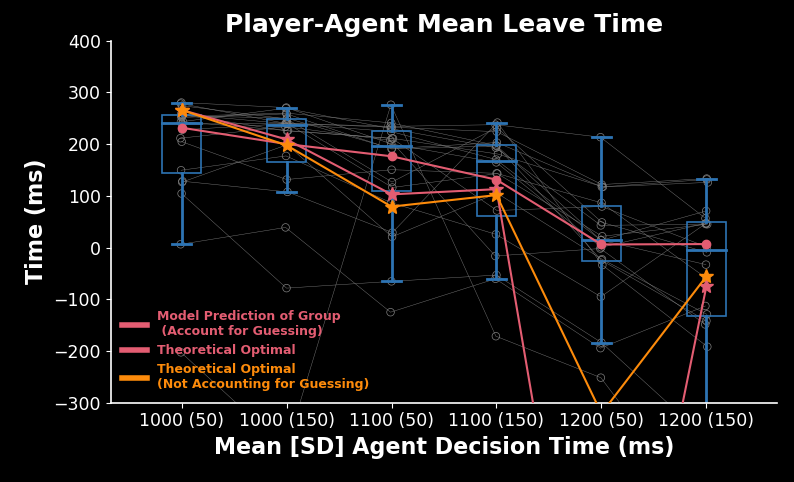

In [373]:
metric = np.nanmedian(group.player_minus_agent_task_leave_time,axis=2)
group_model_metric_true = group_model_true.true_player_minus_agent_leave_time
group_model_metric_expected = group_model_expected.expected_player_minus_agent_leave_time
optimal_model_metric_true = optimal_model_full_knowledge.true_player_minus_agent_leave_time
optimal_model_metric_expected = optimal_model_no_knowledge.expected_player_minus_agent_leave_time
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(-300,500,100)
bw = 0.75
pf.multiple_models_boxplot(ax,metric,optimal_model_full_knowledge.true_gamble_delay ,true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, 
                           expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                           group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
# ax.plot(xlocs,optimal_model_metric,c='orange',marker='o')


ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel('Time (ms)')
ax.set_title('Player-Agent Mean Leave Time')

if save:
    axmain.set_axis_off()
    # plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Wins

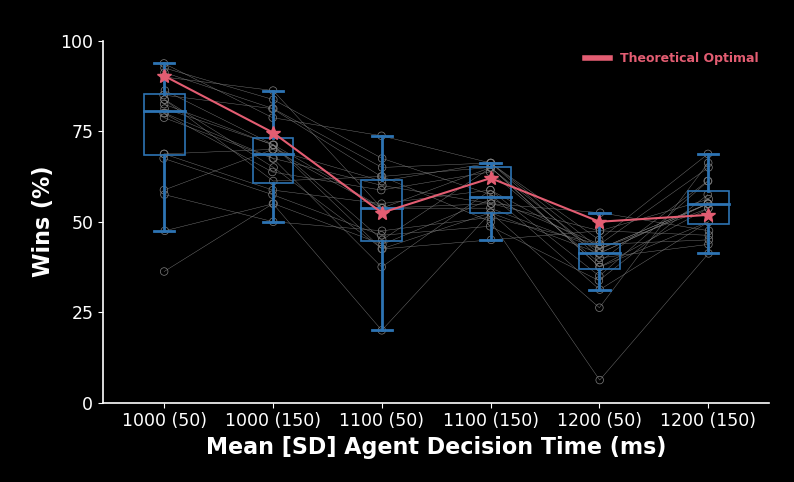

In [401]:
metric = group.player_perc_wins
optimal_model_metric_true = optimal_model_full_knowledge.optimal_true_prob_win*100
group_model_metric_true = group_model_true.optimal_true_prob_win*100
optimal_model_metric_expected = optimal_model_no_knowledge.optimal_true_prob_win*100
group_model_metric_expected = group_model_expected.optimal_expected_prob_win*100

w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,optimal_model_full_knowledge.true_gamble_delay ,true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, 
                           expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                           group_model_true = None, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =None,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,remove_parentheses_from_labels=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Wins (%)')
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Points

In [375]:
if experiment == 'Exp2':
    metric = group.player_points_scored

    optimal_model_metric_true = optimal_model_full_knowledge.max_exp_reward*group.num_task_trials[0]
    group_model_metric_true = group_model_true.expected_reward_of_decision_time*group.num_task_trials[0]
    optimal_model_metric_expected = optimal_model_no_knowledge.max_exp_reward*group.num_task_trials[0]
    group_model_metric_expected = (group_model_expected.expected_reward_of_decision_time*group.num_task_trials[0])

    w,h = 10,6
    axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
    xlocs = np.linspace(0,w,num=len(trial_block_titles))
    ylocs = np.arange(-80,100,40)

    bw = 0.75
    pf.multiple_models_boxplot(ax,metric,optimal_model_full_knowledge.true_gamble_delay ,true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, 
                               expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                               group_model_true = None, group_model_expected = None, 
                            optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                            xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)

    ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
    ax.set_xticks(xlocs),ax.set_yticks(ylocs)
    ax.set_xticklabels(trial_block_titles)
    # ax.set_ylim(0,100)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Points Scored')
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])
    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
    axmain.set_axis_off()
    plt.show()

Incorrects

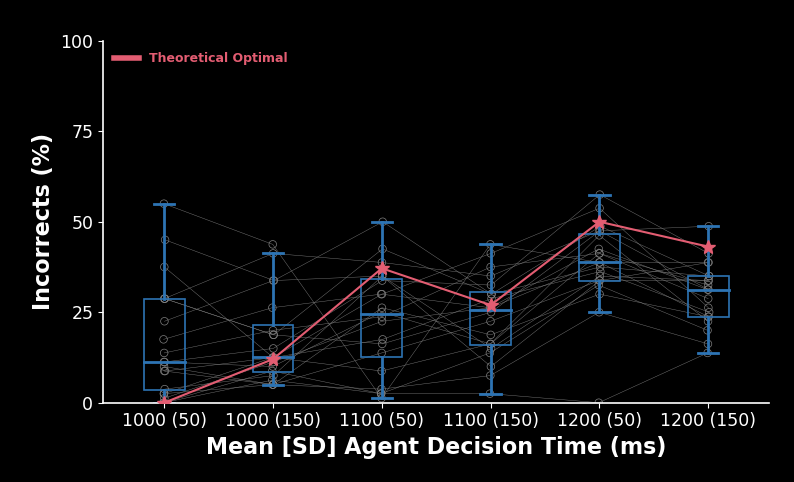

In [402]:
metric = group.player_perc_incorrects
optimal_model_metric_true = optimal_model_full_knowledge.optimal_true_prob_incorrect*100
group_model_metric_true = group_model_true.optimal_true_prob_incorrect*100
optimal_model_metric_expected = optimal_model_no_knowledge.optimal_true_prob_incorrect*100
group_model_metric_expected = group_model_expected.optimal_expected_prob_incorrect*100

w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,optimal_model_full_knowledge.true_gamble_delay ,true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, 
                           expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                           group_model_true = None, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =None,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,remove_parentheses_from_labels=False,legend_loc ='upper left')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Incorrects (%)')
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Indecisions

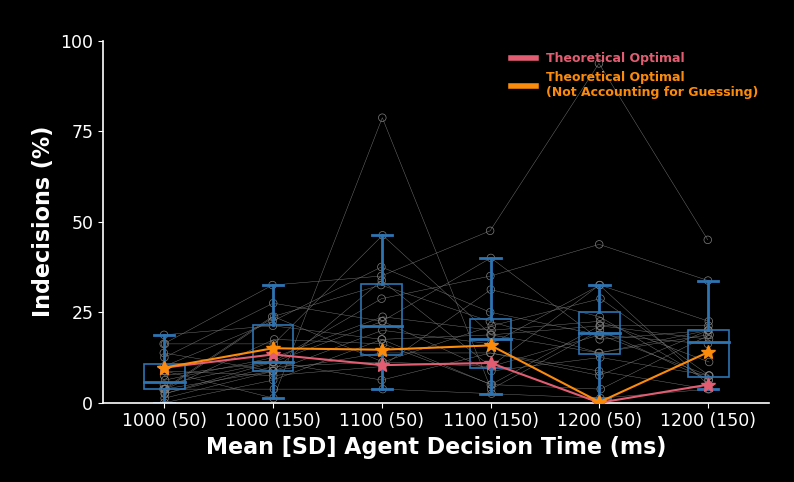

In [440]:
metric = group.player_perc_indecisions
optimal_model_metric_true = optimal_model_full_knowledge.optimal_true_prob_indecision*100
group_model_metric_true = group_model_true.optimal_true_prob_indecision*100
optimal_model_metric_expected = optimal_model_no_knowledge.optimal_true_prob_indecision*100
group_model_metric_expected = group_model_expected.optimal_expected_prob_indecision*100

w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,show_boxplot=True ,true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, 
                           expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,
                           group_model_true = None, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,remove_parentheses_from_labels = False,
                           legend_loc = 'upper right')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Indecisions (%)')

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'indecisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Wins, Incorrects, Indecisions on One plot

Correct Initial Decisions

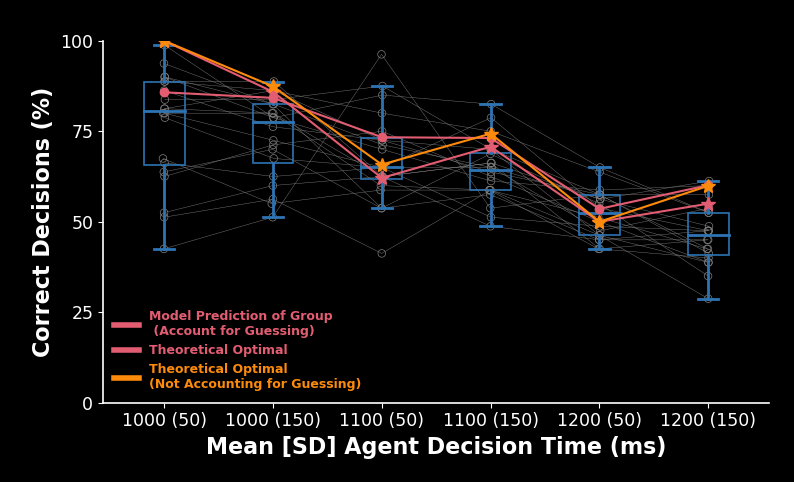

In [379]:
metric = group.phat_correct*100 
optimal_model_metric_true = optimal_model_full_knowledge.optimal_true_phat_correct*100
group_model_metric_true = group_model_true.optimal_true_phat_correct*100
optimal_model_metric_expected = optimal_model_no_knowledge.optimal_expected_phat_correct*100
group_model_metric_expected = group_model_expected.optimal_expected_phat_correct*100

w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,optimal_model_full_knowledge.true_gamble_delay ,true_gamble_sd = optimal_model_full_knowledge.true_gamble_uncertainty, expected_gamble_delay=optimal_model_full_knowledge.expected_gamble_delay,expected_gamble_sd=optimal_model_full_knowledge.expected_gamble_uncertainty,group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Correct Decisions (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Decisions

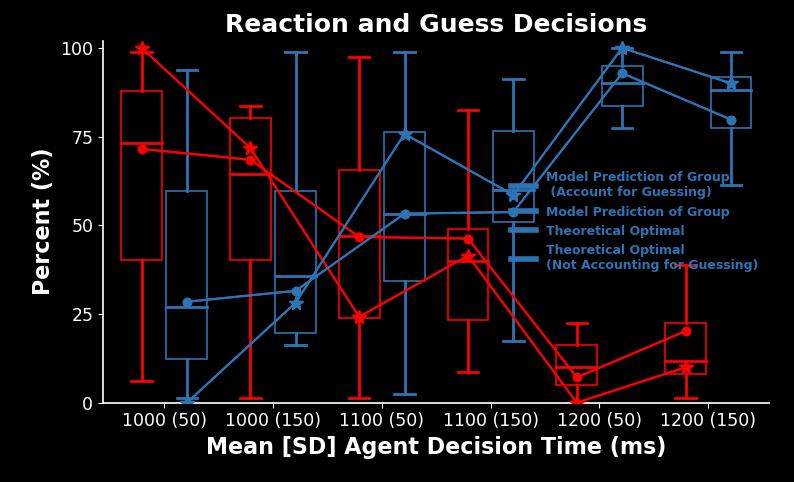

In [380]:
group_model_metric1_expected     = group_model_expected.optimal_expected_prob_selecting_reaction*100
group_model_metric2_expected     = group_model_expected.optimal_expected_prob_selecting_gamble*100
group_model_metric1_true         = group_model_true.optimal_true_prob_selecting_reaction*100
group_model_metric2_true         = group_model_true.optimal_true_prob_selecting_gamble*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_selecting_reaction*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_selecting_gamble*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_selecting_reaction*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_selecting_gamble*100
data_metric1 = group.combine_all_subjects('perc_reaction_decisions')
data_metric2 = group.combine_all_subjects('perc_gamble_decisions')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Reaction and Guess Decisions')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times

c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


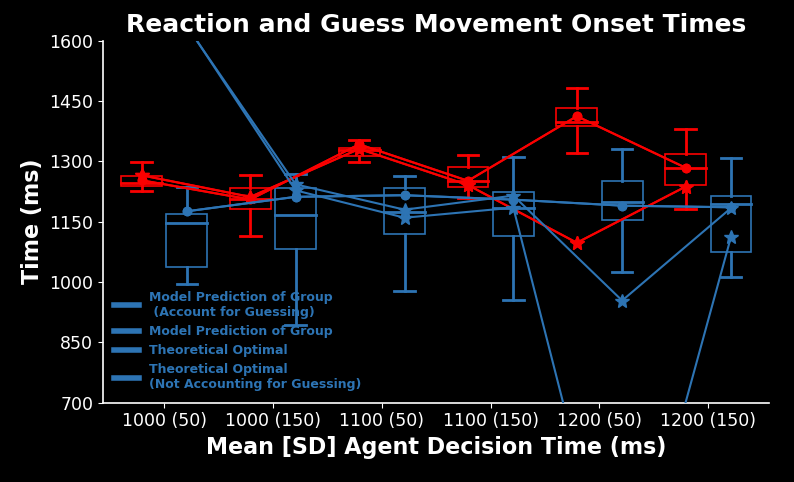

In [420]:
data_metric1 = np.nanmedian(group.player_reaction_task_leave_time,axis=2)
data_metric2 = np.nanmedian(group.player_gamble_task_leave_time,axis=2)

group_model_metric1_expected     = group_model_expected.optimal_expected_reaction_leave_target_time_mean
group_model_metric1_true         = group_model_true.optimal_true_reaction_leave_target_time_mean
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_reaction_leave_target_time_mean
optimal_model_metric1_true       = optimal_model_full_knowledge.optimal_true_reaction_leave_target_time_mean

group_model_metric2_expected     = group_model_expected.optimal_expected_gamble_leave_target_time_mean
group_model_metric2_true         = group_model_true.optimal_true_gamble_leave_target_time_mean
optimal_model_metric2_true       = optimal_model_full_knowledge.optimal_true_gamble_leave_target_time_mean
optimal_model_metric2_expected       = optimal_model_no_knowledge.optimal_true_gamble_leave_target_time_mean

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(700,1750,150)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)
 
ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel(xlabel)
ax.set_title('Reaction and Guess Movement Onset Times')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Decision Times

c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


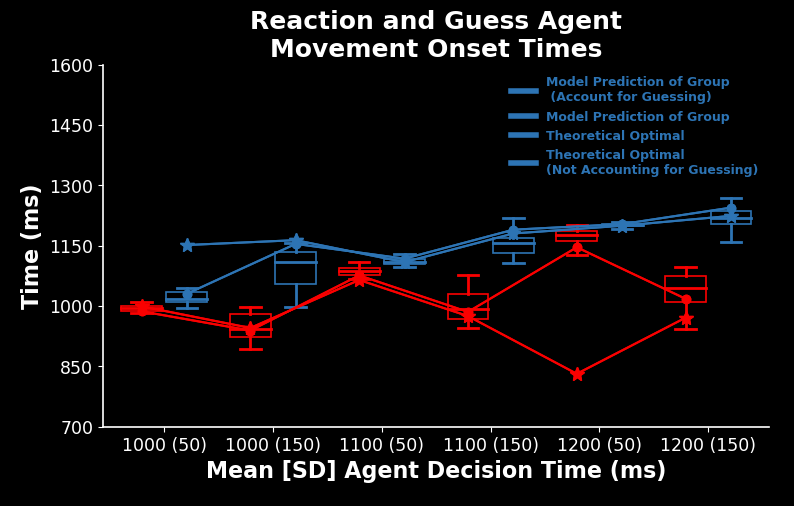

In [382]:

data_metric1 = np.nanmedian(group.agent_reaction_task_leave_time,axis=2)
data_metric2 = np.nanmedian(group.agent_gamble_task_leave_time,axis=2)

group_model_metric1_expected     = group_model_expected.optimal_expected_cutoff_agent_reaction_mean
group_model_metric1_true         = group_model_true.optimal_expected_cutoff_agent_reaction_mean
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_cutoff_agent_reaction_mean
optimal_model_metric1_true       = optimal_model_full_knowledge.optimal_expected_cutoff_agent_reaction_mean

group_model_metric2_expected     = group_model_expected.optimal_expected_cutoff_agent_gamble_mean
group_model_metric2_true         = group_model_true.optimal_expected_cutoff_agent_gamble_mean
optimal_model_metric2_true       = optimal_model_full_knowledge.optimal_expected_cutoff_agent_gamble_mean
optimal_model_metric2_expected       = optimal_model_full_knowledge.optimal_expected_cutoff_agent_gamble_mean

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(700,1750,150)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel(xlabel)
ax.set_title('Reaction and Guess Agent\nMovement Onset Times')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/Gamble

In [383]:
group_model_expected.optimal_expected_prob_indecisions_that_were_reaction

array([0.944782644, 0.690512957, 0.855388225, 0.608615395, 0.359561347,
       0.362546740])

In [419]:
optimal_model_metric2_expected==optimal_model_metric2_true

array([False, False, False, False,  True, False])

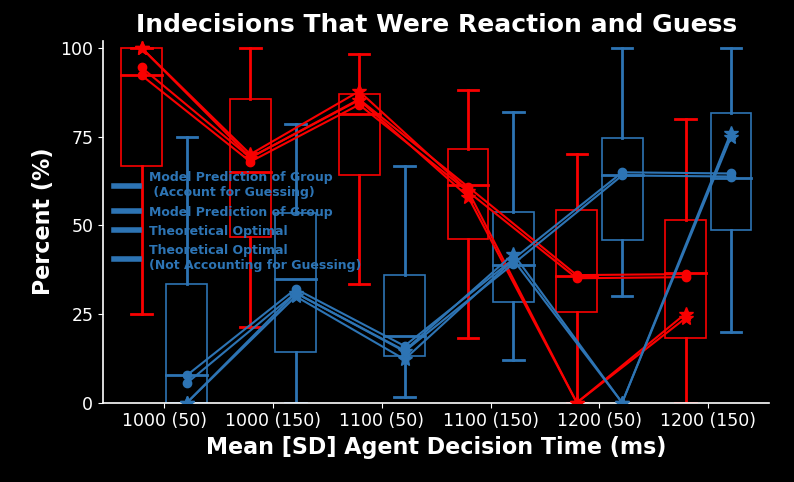

In [418]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.perc_indecisions_that_were_reactions 
data_metric2 = group.perc_indecisions_that_were_gambles 
group_model_metric1_expected     = group_model_expected.optimal_expected_prob_indecisions_that_were_reaction*100
group_model_metric1_true         = group_model_true.optimal_true_prob_indecisions_that_were_reaction*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_indecisions_that_were_reaction*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_indecisions_that_were_reaction*100

group_model_metric2_expected     = group_model_expected.optimal_expected_prob_indecisions_that_were_gamble*100
group_model_metric2_true         = group_model_true.optimal_true_prob_indecisions_that_were_gamble*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_indecisions_that_were_gamble*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_indecisions_that_were_gamble*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Indecisions That Were Reaction and Guess')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Indecisions That Were Gamble

In [424]:
optimal_model_no_knowledge.true_gamble_delay == optimal_model_no_knowledge.expected_gamble_delay

False

In [434]:
optimal_model_full_knowledge.optimal_expected_prob_indecision_gamble

array([0.000000008, 0.039435791, 0.012328643, 0.042925145, 0.000000000,
       0.035476928])

In [433]:
optimal_model_no_knowledge.optimal_expected_prob_indecision_gamble

array([0.000000009, 0.002994428, 0.000829310, 0.002362204, 0.000000003,
       0.001141576])

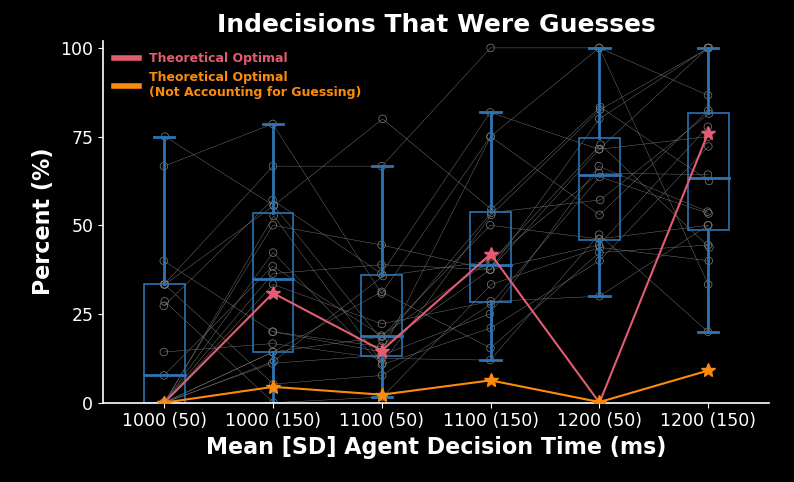

In [426]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric2 = group.perc_indecisions_that_were_gambles 

group_model_metric2_expected     = group_model_expected.optimal_expected_prob_indecisions_that_were_gamble*100
group_model_metric2_true         = group_model_true.optimal_true_prob_indecisions_that_were_gamble*100
optimal_model_metric2_expected   = optimal_model_no_knowledge.optimal_true_prob_indecision_gamble*100
optimal_model_metric2_true       = optimal_model_full_knowledge.optimal_true_prob_indecisions_that_were_gamble*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = None, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,line_colors = None,jitter=True,remove_parentheses_from_labels=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Indecisions That Were Guesses')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

In [409]:
optimal_model_full_knowledge.optimal_true_prob_indecision_gamble*100

array([0.000000772, 4.118700387, 1.526748208, 4.600573140, 0.000000000,
       3.800707963])

In [387]:
group_model_expected.expected_gamble_uncertainty

array([74.730052475, 115.394910923, 90.163114907, 115.572582759,
       134.376678378, 136.978197553])

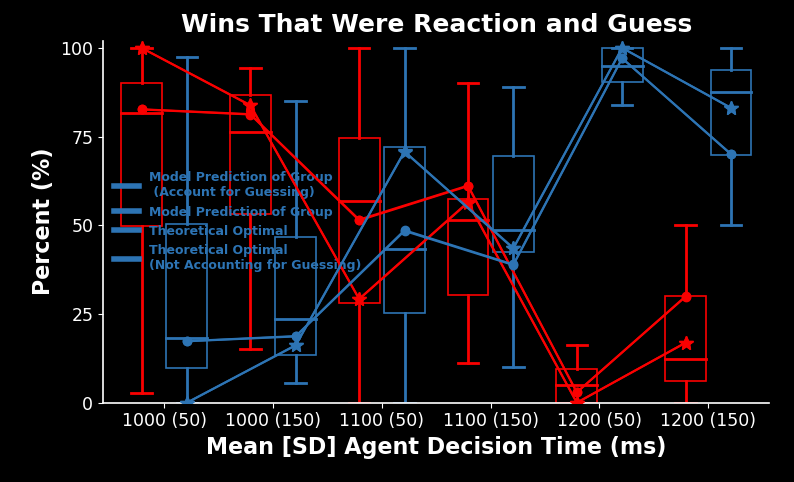

In [388]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.perc_wins_that_were_reactions 
data_metric2 = group.perc_wins_that_were_gambles 
group_model_metric1_expected     = group_model_expected.optimal_expected_prob_wins_that_were_reaction*100
group_model_metric1_true         = group_model_true.optimal_true_prob_wins_that_were_reaction*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_wins_that_were_reaction*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_wins_that_were_reaction*100

group_model_metric2_expected     = group_model_expected.optimal_expected_prob_wins_that_were_gamble*100
group_model_metric2_true         = group_model_true.optimal_true_prob_wins_that_were_gamble*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_wins_that_were_gamble*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_wins_that_were_gamble*100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Wins That Were Reaction and Guess')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Incorrects that were Reaction and Guess

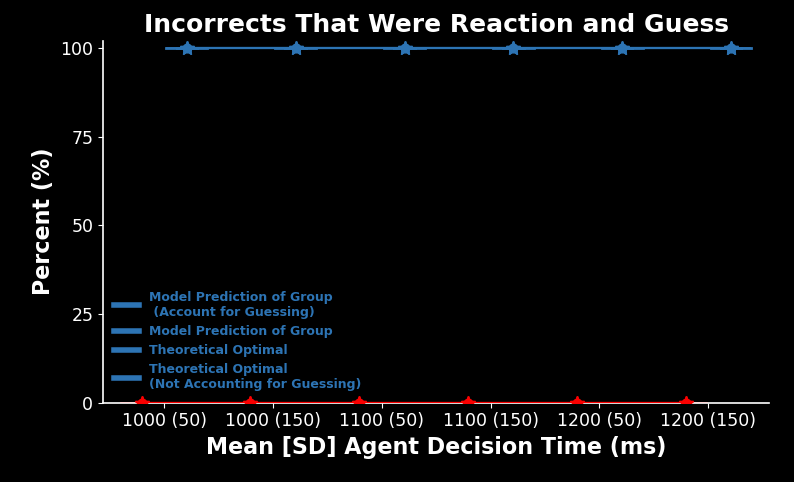

In [389]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.perc_incorrects_that_were_reactions 
data_metric2 = group.perc_incorrects_that_were_gambles 
group_model_metric1_expected     = group_model_expected.optimal_expected_prob_incorrects_that_were_reaction*100
group_model_metric1_true         = group_model_true.optimal_true_prob_incorrects_that_were_reaction*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_incorrects_that_were_reaction*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_incorrects_that_were_reaction*100

group_model_metric2_expected     = group_model_expected.optimal_expected_prob_incorrects_that_were_gamble*100
group_model_metric2_true         = group_model_true.optimal_true_prob_incorrects_that_were_gamble*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_incorrects_that_were_gamble*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_incorrects_that_were_gamble*100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Incorrects That Were Reaction and Guess')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/Gamble How many times did they win

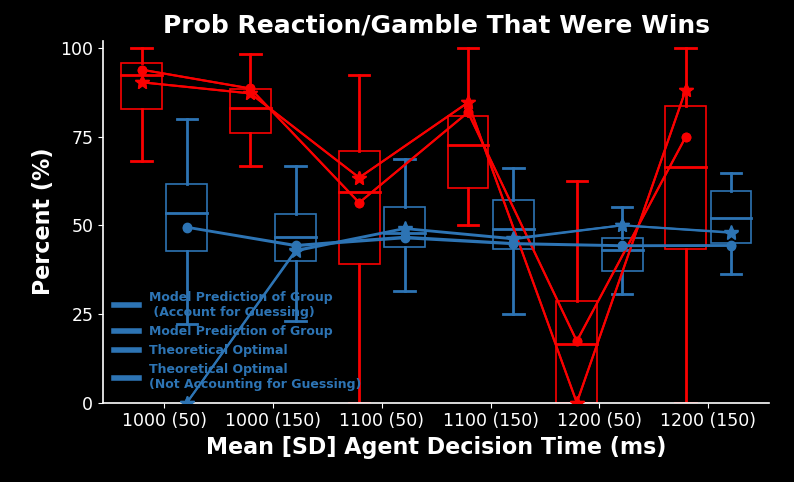

In [390]:
# Out of x number of, wins how many were Reaction and Guess
data_metric1 = group.perc_reactions_that_were_wins 
data_metric2 = group.perc_gambles_that_were_wins 
group_model_metric1_expected     = group_model_expected.optimal_expected_prob_reactions_that_were_wins*100
group_model_metric1_true         = group_model_true.optimal_true_prob_reactions_that_were_wins*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_reactions_that_were_wins*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_reactions_that_were_wins*100

group_model_metric2_expected     = group_model_expected.optimal_expected_prob_gambles_that_were_wins*100
group_model_metric2_true         = group_model_true.optimal_true_prob_gambles_that_were_wins*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_gambles_that_were_wins*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_gambles_that_were_wins*100

# Out of x number of Reaction and Guess decisions, how many of them were
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title( 'Prob Reaction/Gamble That Were Wins')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Indecisions 

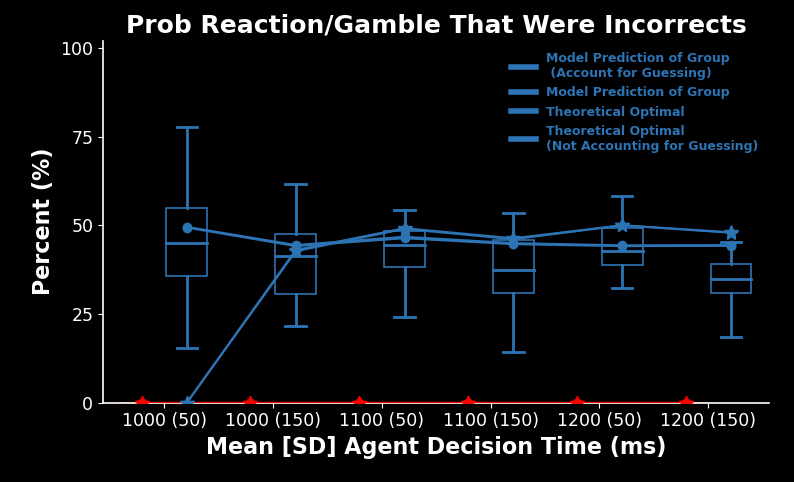

In [391]:
# Out of x number of, incorrects how many were Reaction and Guess
data_metric1 = group.perc_reactions_that_were_incorrects 
data_metric2 = group.perc_gambles_that_were_incorrects 
group_model_metric1_expected     = group_model_expected.optimal_expected_prob_reactions_that_were_incorrects*100
group_model_metric1_true         = group_model_true.optimal_true_prob_reactions_that_were_incorrects*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_reactions_that_were_incorrects*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_reactions_that_were_incorrects*100

group_model_metric2_expected     = group_model_expected.optimal_expected_prob_gambles_that_were_incorrects*100
group_model_metric2_true         = group_model_true.optimal_true_prob_gambles_that_were_incorrects*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_gambles_that_were_incorrects*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_gambles_that_were_incorrects*100

# Out of x number of Reaction and Guess decisions, how many of them were
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title( 'Prob Reaction/Gamble That Were Incorrects')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

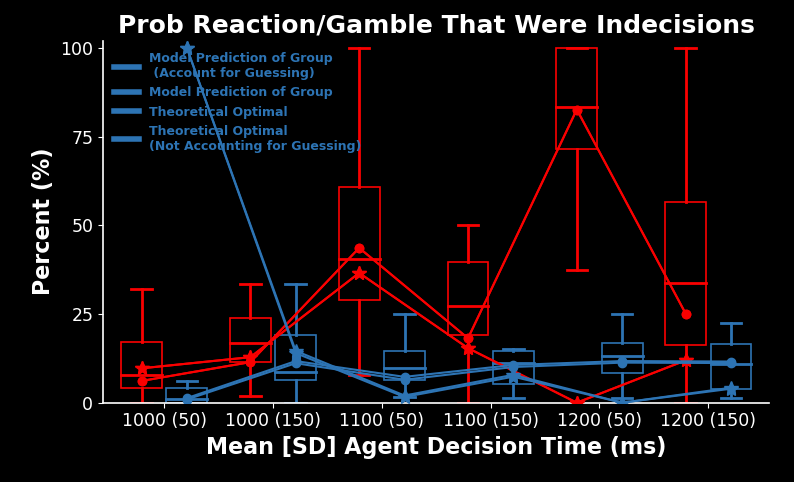

In [392]:
# Out of x number of, indecisions how many were Reaction and Guess
data_metric1 = group.perc_reactions_that_were_indecisions 
data_metric2 = group.perc_gambles_that_were_indecisions 
group_model_metric1_expected     = group_model_expected.optimal_expected_prob_reactions_that_were_indecisions*100
group_model_metric1_true         = group_model_true.optimal_true_prob_reactions_that_were_indecisions*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_reactions_that_were_indecisions*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_reactions_that_were_indecisions*100

group_model_metric2_expected     = group_model_expected.optimal_expected_prob_gambles_that_were_indecisions*100
group_model_metric2_true         = group_model_true.optimal_true_prob_gambles_that_were_indecisions*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_gambles_that_were_indecisions*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_gambles_that_were_indecisions*100

# Out of x number of Reaction and Guess decisions, how many of them were
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true,optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true,optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title( 'Prob Reaction/Gamble That Were Indecisions')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()